# ABTest Filtro Teletrabajo

### Obener datos

Conexión a Amazon Redshift y obtencion del DF con los datos del experimento

In [1]:
f=open("pass.txt","r")
lines=f.readlines()
password=lines[0]
f.close()

In [2]:
import psycopg2
redshift_endpoint = "dataland-internal.big.scmspain.io"
redshift_user = "srv_di_tableau"
redshift_pass = password
port = 5439
dbname = "dwh_sch_sp_db"

In [3]:
from sqlalchemy import create_engine
from sqlalchemy import text
engine_string = "postgresql+psycopg2://%s:%s@%s:%d/%s" \
% (redshift_user, redshift_pass, redshift_endpoint, port, dbname)
engine = create_engine(engine_string)

In [4]:
import pandas as pd
sql = """
with ofertas as (
    select
    dp.id_ad_posting_site as ad,
    date_trunc('day',dp.date_posting) as ad_fecha,
    case when collar_1 not like '%0%' and collar_2 not like '%0%' then concat(concat(dp.collar_1,' - '),dp.collar_2) else 'Sin collar' end as ad_collar,
    case when dp.normalized_name = '' or dp.normalized_name is null then '(Sin normalizar)' else dp.normalized_name end as ad_normalized_name,
    case when dp.normalization_score >= '0.8' then 'High score'
         when dp.normalization_score < '0.8' then 'Low score' end as ad_normalization_score,
    case when pr.id_country = 17 then pr.province else 'En el extranjero' end as ad_province,
    dc.category as ad_category,
   -- dp.is_social_benefit_teleworking as ad_sb_teleworking,
    dtw.teleworking
from
     infojobs_es.dim_publication DP
    join infojobs_es.dim_province  pr                          on dp.id_province = pr.id_province
    join infojobs_es.dim_category dc                           on dp.id_category = dc.id_category
    join infojobs_es.dim_subcategory ds                        on dp.id_subcategory = ds.id_subcategory
    join infojobs_es.dim_posting_model dpm                     on dp.id_posting_model = dpm.id_posting_model
    join infojobs_es.dim_teleworking dtw                       on dp.id_teleworking = dtw.id_teleworking
    where (1=1)
    --and ((trunc(dp.date_posting_iso) between 20180901 and 20200101) or (trunc(dp.date_posting_iso) >= 20210101))
    and date_posting_iso >= 20211201
    and dp.date_end_iso = 99991231
    and dp.is_redirect is false
    and pr.id_country = 17
    and teleworking in ('Solo teletrabajo','Teletrabajo posible','(Seleccionar)','Trabajo solo presencial','No se sabe/No está decidido')
group by
    dp.id_ad_posting_site,
    dp.date_end_iso,
    date_trunc('day',dp.date_posting),
    case when pr.id_country = 17 then pr.province else 'En el extranjero' end,
    case when collar_1 not like '%0%' and collar_2 not like '%0%' then concat(concat(dp.collar_1,' - '),dp.collar_2) else 'Sin collar' end,
    case when dp.normalized_name = '' or dp.normalized_name is null then '(Sin normalizar)' else dp.normalized_name end,
    case when dp.normalization_score >= '0.8' then 'High score'
         when dp.normalization_score < '0.8' then 'Low score' end,
    pr.province,
    dc.category ,
    --dp.is_social_benefit_teleworking,
    dtw.teleworking
    ),
inscripciones as (
    select
    date_trunc('day',date_hit) as hit_date,
    fh.id_ad_posting_site as id_ad,
    sum(case when id_hit_type=22 then 1 else 0 end) as inscripciones,
    sum(case when id_hit_type =1 then 1 else 0 end) as visualizaciones,
    case when hym >= '0.65' then 'Calidad'
        when hym < '0.65' then 'No calidad' else 'Null' end as calidad_hym,
    dr.group_referer,
   -- dr.referer,
case
    when src_platform = 'API_iosapp_ij' then 'iOS'
    when src_platform = 'IJ_WEB' and src_device = 'pc' then 'Web'
    when src_platform = 'IJ_WEB' and src_device in ('movil', 'tablet') then 'Web mobile'
    when src_platform = 'API_android_ij' then 'Android'
    else 'Otros' end as platform,
    fh.trace_version
from
    infojobs_es.fact_hit fh
    join infojobs_es.dim_referer dr     on fh.id_referer = dr.id_referer
    where id_hit_type in (22,1)
    --and ((trunc(date_hit_iso) between 20190101 and 20200101) or (trunc(date_hit_iso) >= 20210101))
    and (trunc(date_hit_iso) >= 20220302)
    and group_referer = 'Search'
    and trace_version in ('teleworking_inactive',
'teleworking_active'
)
group by
    date_trunc('day',date_hit),
    fh.id_ad_posting_site,
    case when hym >= '0.65' then 'Calidad'
         when hym < '0.65' then 'No calidad' else 'Null' end,
     dr.group_referer,
    -- dr.referer,
    case
    when src_platform = 'API_iosapp_ij' then 'iOS'
    when src_platform = 'IJ_WEB' and src_device = 'pc' then 'Web'
    when src_platform = 'IJ_WEB' and src_device in ('movil', 'tablet') then 'Web mobile'
    when src_platform = 'API_android_ij' then 'Android' else 'Otros' end,
    fh.trace_version
    )
select  /*+  use_hash(inscripciones, candidatos, ofertas )  */
       ofertas.ad,
       sum(inscripciones) as inscripciones,
       sum(visualizaciones) as visualizaciones,
       --inscripciones.hit_date,
       --inscripciones.calidad_hym,
       --inscripciones.group_referer,
      -- inscripciones.referer,
       --inscripciones.platform,
       inscripciones.trace_version,
    --ofertas.ad_fecha,
    --ofertas.ad_collar,
    --ofertas.ad_normalized_name,
   -- ofertas.ad_normalization_score,
   -- ofertas.ad_province,
   -- ofertas.ad_category,
   -- ofertas.ad_sb_teleworking,
    ofertas.teleworking
    --ofertas.ad_posting_model --está mal
from inscripciones left join ofertas on ofertas.ad = inscripciones.id_ad
group by
          ofertas.ad,
       -- inscripciones.platform,
       -- inscripciones.hit_date,
       -- inscripciones.calidad_hym,
      --  inscripciones.group_referer,
       -- inscripciones.referer,
        inscripciones.trace_version,
   -- ofertas.ad_fecha,
   -- ofertas.ad_collar,
   -- ofertas.ad_normalized_name,
   -- ofertas.ad_normalization_score,
   -- ofertas.ad_province,
   -- ofertas.ad_category,
    --ofertas.ad_sb_teleworking,
    ofertas.teleworking;
"""

In [5]:
raw_data = pd.read_sql_query(text(sql), engine)

In [6]:
#eliminamos rows con ad id nulos
raw_data = raw_data.dropna(subset=["ad"])

In [7]:
raw_data.head(5)

,ad,inscripciones,visualizaciones,trace_version,teleworking
0,4.382606e+18,6,58,teleworking_active,Trabajo solo presencial
1,4.382599e+18,2,14,teleworking_inactive,No se sabe/No está decidido
2,4.375411e+18,3,12,teleworking_active,Trabajo solo presencial
3,4.382870e+18,7,41,teleworking_inactive,Trabajo solo presencial
4,4.329200e+18,8,56,teleworking_inactive,Teletrabajo posible


In [8]:
datos=raw_data.groupby(['ad','trace_version'])['visualizaciones'].sum().reset_index()
datos.head(5)

,ad,trace_version,visualizaciones
0,1.856036e+17,teleworking_active,172
1,1.856036e+17,teleworking_inactive,181
2,9.016174e+17,teleworking_active,39
3,9.016174e+17,teleworking_inactive,25
4,2.030862e+18,teleworking_active,6


### Tratamiento de datos

In [9]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración matplotlib
# ==============================================================================
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Varios
# ==============================================================================
from tqdm import tqdm

In [10]:
#df_csv = pd.read_csv('data.csv')#, encoding='latin-1', sep='|', header=None)

In [11]:
datos=datos[['trace_version','visualizaciones']]

In [12]:
datos.head(5)

,trace_version,visualizaciones
0,teleworking_active,172
1,teleworking_inactive,181
2,teleworking_active,39
3,teleworking_inactive,25
4,teleworking_active,6


In [13]:
#datos=datos[(datos['visualizaciones']<100) & (datos['visualizaciones']>=0)]

In [14]:
#limpieza de valores anomalos
y = datos['visualizaciones']
removed_outliers = y.between(y.quantile(.00), y.quantile(.99))

In [15]:
datos=datos[removed_outliers]

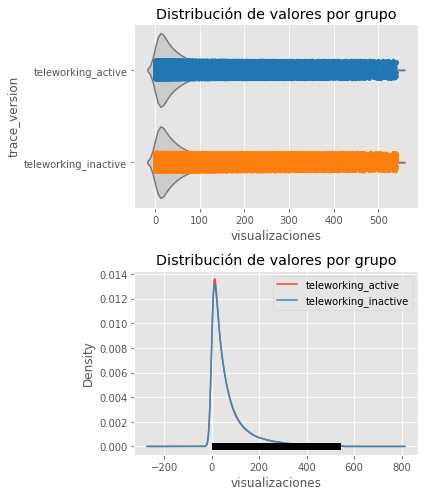

In [16]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))
sns.violinplot(
    x     = datos.visualizaciones,
    y     = datos.trace_version,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.visualizaciones,
    y    = datos.trace_version,
    data = datos,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('trace_version')
axs[0].set_xlabel('visualizaciones');

for grupo in datos.trace_version.unique():
    datos_temp = datos[datos.trace_version == grupo]['visualizaciones']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('visualizaciones');
axs[1].legend()

fig.tight_layout();

In [17]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='trace_version').describe()

visualizaciones                                         \
                               count       mean        std  min   25%   50%   
trace_version                                                                 
teleworking_active           87292.0  68.936352  84.821849  0.0  15.0  38.0   
teleworking_inactive         88364.0  70.572394  85.749130  0.0  15.0  40.0   

                                   
                       75%    max  
trace_version                      
teleworking_active    87.0  542.0  
teleworking_inactive  90.0  542.0

In [18]:
def dif_mean(x1, x2):
    '''
    Función para calcular la diferencia de medias entre dos grupos.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    
    estadistico = np.mean(x1) - np.mean(x2)
    return(estadistico)

In [19]:
dif_observada = dif_mean(
                    x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                    x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones']
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: -1.636042179307097


hay una diferencia de -2 visualizaciones promedio para las ofertas que estan dentro del test, pero no sabemos si corresponde a la aleatoriedad de una distribucion normal, por lo cual haremos Booststrapping:

### Aplicar Booststrapping

El objetivo del estudio es determinar si, la diferencia observada de -2 visualizaciones, está dentro de lo que cabría esperar debido únicamente al muestreo aleatorio, si no existiera diferencia real entre las poblaciones

Si se obtuviera una nueva muestra de estudiantes, la diferencia promedio entre grupos sería ligeramente distinta, aunque no existiera una diferencia real entre nacionalidades. Por lo tanto, dar respuesta a este problema pasa por determinar cuánta diferencia se espera por el simple hecho de repetir el muestreo.

Mediante bootstrapping, se generan nuevas pseudo-muestras de individuos empleando las dos muestras originales (Variante 1 y Variante 2) combinadas. Con cada una de las pseudo-muestras, se generan dos grupos de tamaños iguales a los grupos de las muestras originales y se calcula la diferencia del estadístico, en este caso la media.

In [20]:
def calcular_estadistico(x):
    '''
    Función para calcular el estadístico de interés.
    
    Parameters
    ----------
    x : numpy array
         valores de la muestra.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    estadistico = np.mean(x)
    
    return(estadistico)


def bootstraping_2_grupos(x1, x2, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular la diferencia de un estadístico entre dos grupos en
    múltiples muestras generadas mediante muestreo repetido con reposición
    (bootstrapping) de forma separada para cada grupo.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra del grupo 1.
         
    x2 : numpy array
         valores de la muestra del grupo 2.
 
    fun_estadistico : function
        función que recibe como argumento una muestra y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número iteraciones (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        diferencia entre ambos grupos en cada muestra de bootstrapping.
    '''
    
    n1 = len(x1)
    n2 = len(x2)
    dist_boot = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        # Se crea una nueva muestra de cada grupo
        resample_1 = np.random.choice(x1, size=n1, replace=True)
        resample_2 = np.random.choice(x2, size=n2, replace=True)
        # Se calcula el estadístico para cada grupo
        estadistico_1 = fun_estadistico(resample_1)
        estadistico_2 = fun_estadistico(resample_2)
        # Diferencia entre estadísticos
        dist_boot[i]  = estadistico_1 - estadistico_2
        
    return dist_boot

In [21]:
dist_boot = bootstraping_2_grupos(
                x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones'],
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:35<00:00, 278.36it/s]


In [22]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[-2.42629879 -0.83195236]


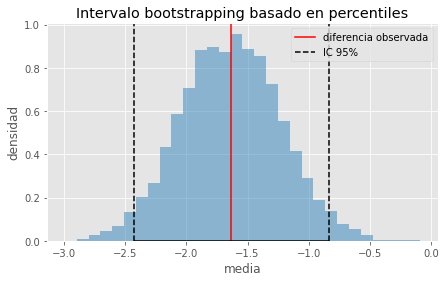

In [23]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basado en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();


Sí existen evidencias para afirmar que las visualizaciones promedio de ofertas entre los dos grupos es distinto. El intervalo de confianza del 95% para la diferencia de medias obtenido por bootstrapping indica que, en promedio, las visualizaciones del grupo Telework_Active disminuyen de -1,3 a -2,6 visualizaciones promedio.

### Solo Teletrabajo

In [24]:
datos=raw_data[(raw_data['teleworking']=='Solo teletrabajo')] #| (raw_data['teleworking']>=0)]
datos.head(5)

,ad,inscripciones,visualizaciones,trace_version,teleworking
32,4.368717e+18,1,17,teleworking_active,Solo teletrabajo
33,4.386947e+18,6,21,teleworking_inactive,Solo teletrabajo
65,4.383462e+18,5,35,teleworking_inactive,Solo teletrabajo
98,4.379382e+18,1,45,teleworking_inactive,Solo teletrabajo
103,4.383212e+18,3,27,teleworking_active,Solo teletrabajo


In [25]:
datos=datos.groupby(['ad','trace_version'])['visualizaciones'].sum().reset_index()
datos.head(5)

,ad,trace_version,visualizaciones
0,3.640686e+18,teleworking_active,4
1,3.640686e+18,teleworking_inactive,7
2,3.666604e+18,teleworking_active,179
3,3.666604e+18,teleworking_inactive,142
4,3.952505e+18,teleworking_active,155


In [26]:
#df_csv = pd.read_csv('datos_teletrabajo.csv')#, encoding='latin-1', sep='|', header=None)

In [27]:
datos=datos[['trace_version','visualizaciones']]
datos.head(5)

,trace_version,visualizaciones
0,teleworking_active,4
1,teleworking_inactive,7
2,teleworking_active,179
3,teleworking_inactive,142
4,teleworking_active,155


In [28]:
y = datos['visualizaciones']
removed_outliers = y.between(y.quantile(.00), y.quantile(.99))

In [29]:
datos = datos[removed_outliers]

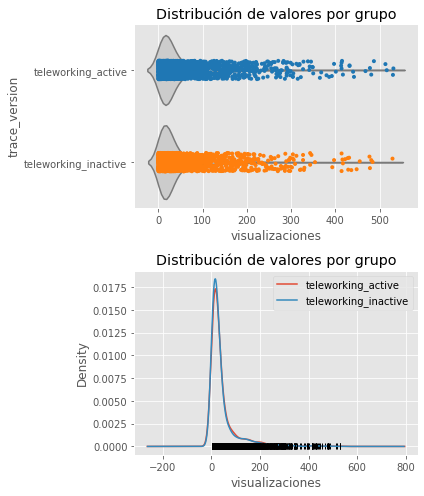

In [30]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))
sns.violinplot(
    x     = datos.visualizaciones,
    y     = datos.trace_version,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.visualizaciones,
    y    = datos.trace_version,
    data = datos,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('trace_version')
axs[0].set_xlabel('visualizaciones');

for grupo in datos.trace_version.unique():
    datos_temp = datos[datos.trace_version == grupo]['visualizaciones']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('visualizaciones');
axs[1].legend()

fig.tight_layout();

In [31]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='trace_version').describe()

visualizaciones                                         \
                               count       mean        std  min   25%   50%   
trace_version                                                                 
teleworking_active            3361.0  44.827432  64.950462  1.0  12.0  23.0   
teleworking_inactive          3375.0  41.318815  59.911165  1.0  11.0  22.0   

                                   
                       75%    max  
trace_version                      
teleworking_active    45.0  531.0  
teleworking_inactive  41.0  529.0

A diferencia del total de datos si miramos solo teletrabajo, el minimo es 1, es decir estas ofertas siempre o generalmete reciben al menos una visualización


In [32]:
dif_observada = dif_mean(
                    x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                    x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones']
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: 3.5086174969971466


In [33]:
dist_boot = bootstraping_2_grupos(
                x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones'],
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:01<00:00, 6145.64it/s]


In [34]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[0.52710266 6.58570754]


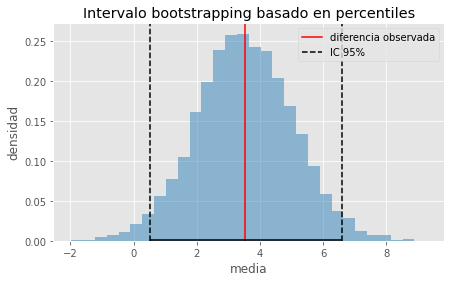

In [35]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basado en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

Sí existen evidencias para afirmar que las visualizaciones promedio de ofertas entre los dos grupos es distinto. El intervalo de confianza del 95% para la diferencia de medias obtenido por bootstrapping indica que, en promedio, las visualizaciones del grupo Telework_Active aumentan hasta de 4 visualizaciones promedio con una media de 2

### Teletrabajo posible

In [36]:
datos=raw_data[(raw_data['teleworking']=='Teletrabajo posible')] #| (raw_data['teleworking']>=0)]
datos.head(5)

,ad,inscripciones,visualizaciones,trace_version,teleworking
4,4.329200e+18,8,56,teleworking_inactive,Teletrabajo posible
10,4.360261e+18,8,35,teleworking_active,Teletrabajo posible
18,4.331231e+18,0,10,teleworking_inactive,Teletrabajo posible
23,4.363326e+18,5,41,teleworking_inactive,Teletrabajo posible
26,4.368587e+18,5,100,teleworking_inactive,Teletrabajo posible


In [37]:
datos=datos.groupby(['ad','trace_version'])['visualizaciones'].sum().reset_index()

datos=datos[['trace_version','visualizaciones']]

y = datos['visualizaciones']
removed_outliers = y.between(y.quantile(.00), y.quantile(.99))
datos = datos[removed_outliers]

datos.head(5)

,trace_version,visualizaciones
0,teleworking_active,115
1,teleworking_inactive,114
2,teleworking_active,37
3,teleworking_inactive,17
4,teleworking_active,40


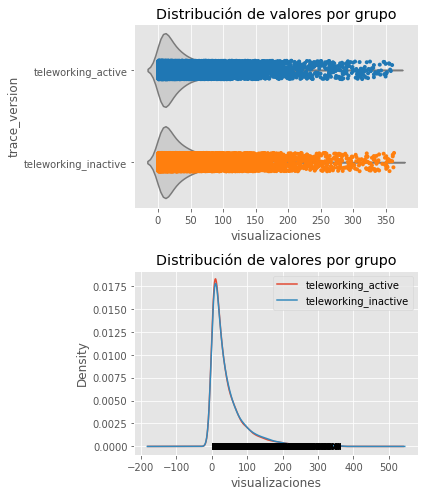

In [38]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))
sns.violinplot(
    x     = datos.visualizaciones,
    y     = datos.trace_version,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.visualizaciones,
    y    = datos.trace_version,
    data = datos,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('trace_version')
axs[0].set_xlabel('visualizaciones');

for grupo in datos.trace_version.unique():
    datos_temp = datos[datos.trace_version == grupo]['visualizaciones']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('visualizaciones');
axs[1].legend()

fig.tight_layout();

In [39]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='trace_version').describe()

visualizaciones                                         \
                               count       mean        std  min   25%   50%   
trace_version                                                                 
teleworking_active           12914.0  44.857751  53.095131  0.0  10.0  26.0   
teleworking_inactive         13060.0  46.371669  54.577701  0.0  11.0  27.0   

                                   
                       75%    max  
trace_version                      
teleworking_active    59.0  360.0  
teleworking_inactive  61.0  363.0

In [40]:
dif_observada = dif_mean(
                    x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                    x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones']
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: -1.513917941306147


In [41]:
dist_boot = bootstraping_2_grupos(
                x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones'],
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:04<00:00, 2255.00it/s]


In [42]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[-2.83462377 -0.22048008]


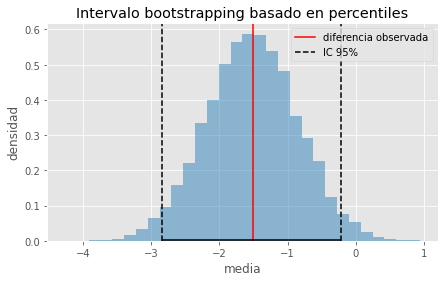

In [43]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basado en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

Sí existen evidencias para afirmar que las visualizaciones promedio de ofertas entre los dos grupos es distinto. El intervalo de confianza del 95% para la diferencia de medias obtenido por bootstrapping indica que, en promedio, las visualizaciones del grupo Telework_Active disminuyen entre -0,3 a -2,6 visualizaciones promedio.

## Ofertas sin Teletrabajo o no esta definido

In [44]:
datos=raw_data[(raw_data['teleworking']=='(Seleccionar)')
               |(raw_data['teleworking']=='Trabajo solo presencial')
               |(raw_data['teleworking']=='No se sabe/No está decidido')]
datos.head(5)

,ad,inscripciones,visualizaciones,trace_version,teleworking
0,4.382606e+18,6,58,teleworking_active,Trabajo solo presencial
1,4.382599e+18,2,14,teleworking_inactive,No se sabe/No está decidido
2,4.375411e+18,3,12,teleworking_active,Trabajo solo presencial
3,4.382870e+18,7,41,teleworking_inactive,Trabajo solo presencial
6,4.330017e+18,5,36,teleworking_active,Trabajo solo presencial


In [45]:
datos=datos.groupby(['ad','trace_version'])['visualizaciones'].sum().reset_index()

datos=datos[['trace_version','visualizaciones']]

y = datos['visualizaciones']
removed_outliers = y.between(y.quantile(.00), y.quantile(.99))
datos = datos[removed_outliers]

datos.head(5)

,trace_version,visualizaciones
0,teleworking_active,172
1,teleworking_inactive,181
2,teleworking_active,39
3,teleworking_inactive,25
4,teleworking_active,6


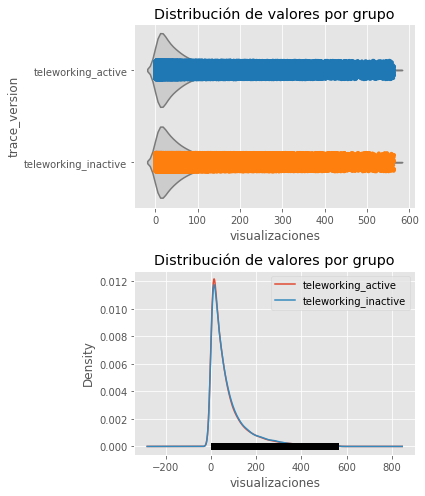

In [46]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))
sns.violinplot(
    x     = datos.visualizaciones,
    y     = datos.trace_version,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.visualizaciones,
    y    = datos.trace_version,
    data = datos,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('trace_version')
axs[0].set_xlabel('visualizaciones');

for grupo in datos.trace_version.unique():
    datos_temp = datos[datos.trace_version == grupo]['visualizaciones']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('visualizaciones');
axs[1].legend()

fig.tight_layout();

In [47]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='trace_version').describe()

visualizaciones                                         \
                               count       mean        std  min   25%   50%   
trace_version                                                                 
teleworking_active           71023.0  74.651000  90.088067  0.0  17.0  43.0   
teleworking_inactive         71913.0  76.388052  90.707713  0.0  17.0  44.0   

                                   
                       75%    max  
trace_version                      
teleworking_active    95.0  564.0  
teleworking_inactive  98.0  564.0

In [48]:
dif_observada = dif_mean(
                    x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                    x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones']
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: -1.7370518496191067


In [49]:
dist_boot = bootstraping_2_grupos(
                x2 = datos[datos.trace_version == 'teleworking_inactive']['visualizaciones'],
                x1 = datos[datos.trace_version == 'teleworking_active']['visualizaciones'],
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:41<00:00, 242.10it/s]


In [50]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[-2.68143119 -0.79882643]


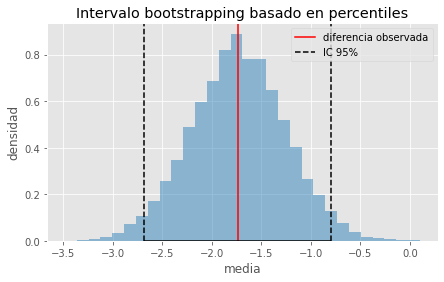

In [51]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basado en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

Sí existen evidencias para afirmar que las visualizaciones promedio de ofertas entre los dos grupos es distinto. El intervalo de confianza del 95% para la diferencia de medias obtenido por bootstrapping indica que, en promedio, las visualizaciones del grupo Telework_Active disminuyen entre -1,4 a -3 visualizaciones promedio.

## Otros insights


In [143]:
datos=raw_data.groupby(['ad','teleworking'])['inscripciones'].sum().reset_index()
datos.head(5)

,ad,teleworking,inscripciones
0,1.856036e+17,Trabajo solo presencial,67
1,9.016174e+17,Trabajo solo presencial,3
2,2.030862e+18,Trabajo solo presencial,9
3,2.301934e+18,Trabajo solo presencial,19
4,2.437888e+18,No se sabe/No está decidido,12


In [152]:
datos=datos[['teleworking','inscripciones']]

In [145]:
#limpieza de valores anomalos
y = datos['inscripciones']
removed_outliers = y.between(y.quantile(.00), y.quantile(.99))
datos=datos[removed_outliers]

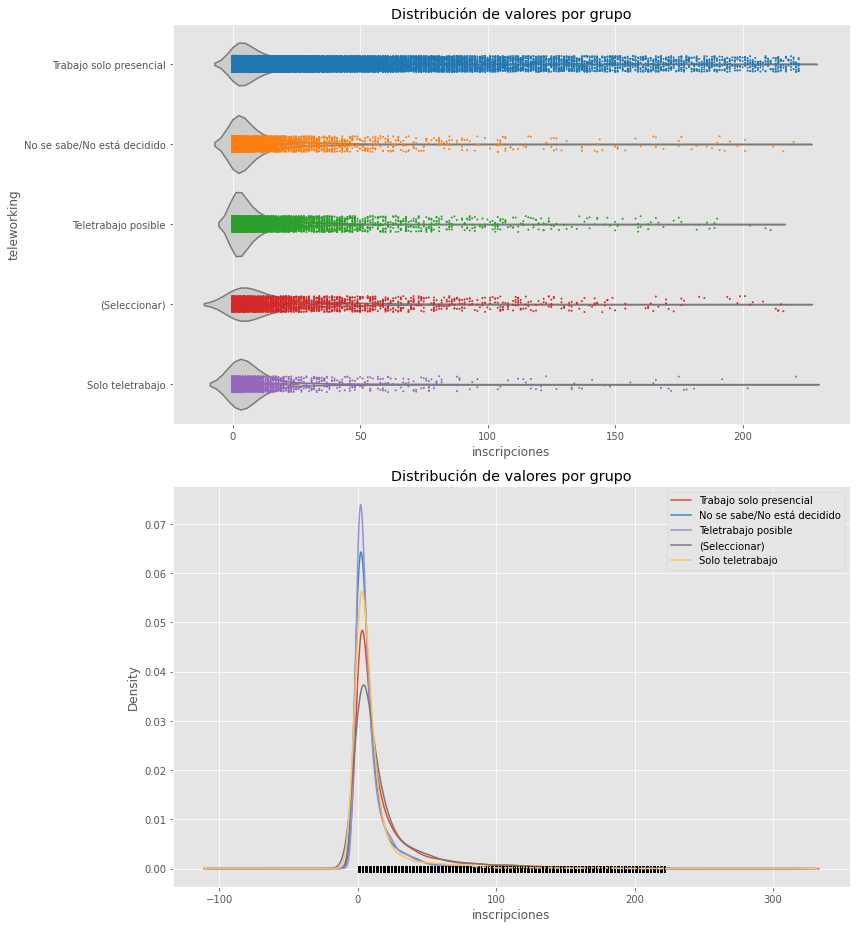

In [153]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 13))
sns.violinplot(
    x     = datos.inscripciones,
    y     = datos.teleworking,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.inscripciones,
    y    = datos.teleworking,
    data = datos,
    size = 2,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('teleworking')
axs[0].set_xlabel('inscripciones');

for grupo in datos.teleworking.unique():
    datos_temp = datos[datos.teleworking == grupo]['inscripciones']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('inscripciones');
axs[1].legend()

fig.tight_layout();

In [154]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='teleworking').describe()

inscripciones                                  \
                                    count       mean        std  min  25%   
teleworking                                                                 
(Seleccionar)                      3829.0  19.026639  29.300783  0.0  2.0   
No se sabe/No está decidido        5782.0  10.464026  20.124599  0.0  1.0   
Solo teletrabajo                   2591.0  10.988421  21.463066  0.0  1.0   
Teletrabajo posible               11474.0  10.104671  17.959709  0.0  1.0   
Trabajo solo presencial           52969.0  19.694236  31.453919  0.0  3.0   

                                               
                             50%   75%    max  
teleworking                                    
(Seleccionar)                8.0  21.0  216.0  
No se sabe/No está decidido  4.0  11.0  220.0  
Solo teletrabajo             5.0  11.0  221.0  
Teletrabajo posible          4.0  11.0  211.0  
Trabajo solo presencial      8.0  22.0  222.0

In [155]:
datos=raw_data.groupby(['ad','teleworking'])['visualizaciones'].sum().reset_index()
datos.head(5)

,ad,teleworking,visualizaciones
0,1.856036e+17,Trabajo solo presencial,243
1,9.016174e+17,Trabajo solo presencial,56
2,2.030862e+18,Trabajo solo presencial,24
3,2.301934e+18,Trabajo solo presencial,384
4,2.437888e+18,No se sabe/No está decidido,110


In [157]:
#limpieza de valores anomalos
y = datos['visualizaciones']
removed_outliers = y.between(y.quantile(.00), y.quantile(.99))
datos=datos[removed_outliers]

In [159]:
datos=datos[['teleworking','visualizaciones']]

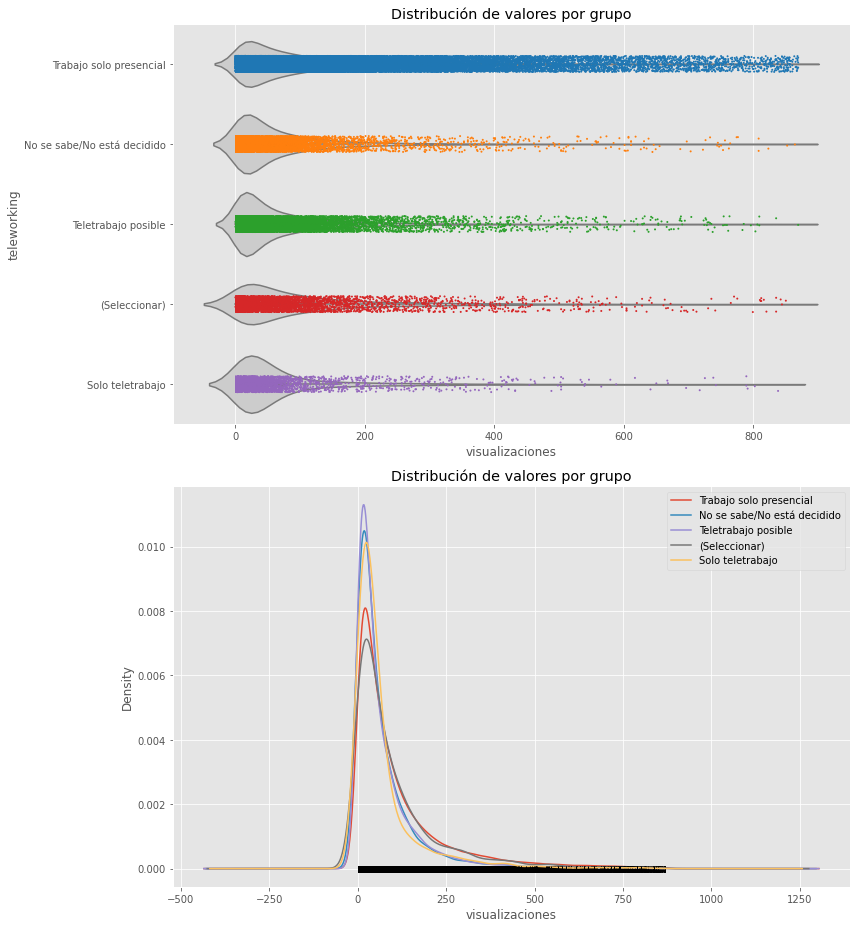

In [161]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 13))
sns.violinplot(
    x     = datos.visualizaciones,
    y     = datos.teleworking,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.visualizaciones,
    y    = datos.teleworking,
    data = datos,
    size = 2,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('teleworking')
axs[0].set_xlabel('visualizaciones');

for grupo in datos.teleworking.unique():
    datos_temp = datos[datos.teleworking == grupo]['visualizaciones']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('visualizaciones');
axs[1].legend()

fig.tight_layout();

In [162]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='teleworking').describe()

visualizaciones                               \
                                      count        mean         std  min   
teleworking                                                                
(Seleccionar)                        3839.0  101.524355  126.844932  0.0   
No se sabe/No está decidido          5770.0   71.345581   99.030078  1.0   
Solo teletrabajo                     2578.0   70.133049  100.040255  1.0   
Teletrabajo posible                 11458.0   71.468755   97.082748  0.0   
Trabajo solo presencial             52995.0  113.369978  140.737084  0.0   

                                                       
                              25%   50%    75%    max  
teleworking                                            
(Seleccionar)                19.0  56.0  129.0  850.0  
No se sabe/No está decidido  14.0  37.0   87.0  864.0  
Solo teletrabajo             16.0  37.0   75.0  838.0  
Teletrabajo posible          14.0  37.0   89.0  869.0  
Trabajo solo presencial      24.0  62.0  143.0  869.0

## Inscripciones en el test

In [169]:
datos=raw_data[(raw_data['teleworking']=='Solo teletrabajo')] #| (raw_data['teleworking']>=0)]
datos.head(5)

,ad,inscripciones,visualizaciones,trace_version,teleworking
24,4.383989e+18,2,22,teleworking_inactive,Solo teletrabajo
148,4.327168e+18,0,9,teleworking_active,Solo teletrabajo
192,4.362692e+18,0,1,teleworking_active,Solo teletrabajo
199,4.386605e+18,2,10,teleworking_inactive,Solo teletrabajo
201,4.381607e+18,1,7,teleworking_inactive,Solo teletrabajo


In [170]:
datos=datos.groupby(['ad','trace_version'])['inscripciones'].sum().reset_index()
datos.head(5)

,ad,trace_version,inscripciones
0,3.640686e+18,teleworking_active,2
1,3.640686e+18,teleworking_inactive,1
2,3.666604e+18,teleworking_active,12
3,3.666604e+18,teleworking_inactive,9
4,3.952505e+18,teleworking_active,12


In [100]:
#df_csv = pd.read_csv('datos_teletrabajo.csv')#, encoding='latin-1', sep='|', header=None)

In [171]:
datos=datos[['trace_version','inscripciones']]
datos.head(5)

,trace_version,inscripciones
0,teleworking_active,2
1,teleworking_inactive,1
2,teleworking_active,12
3,teleworking_inactive,9
4,teleworking_active,12


In [173]:
y = datos['inscripciones']
removed_outliers = y.between(y.quantile(.00), y.quantile(.99))

In [174]:
datos = datos[removed_outliers]

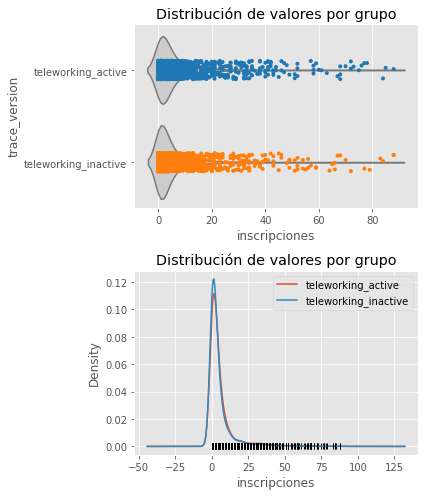

In [175]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))
sns.violinplot(
    x     = datos.inscripciones,
    y     = datos.trace_version,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.inscripciones,
    y    = datos.trace_version,
    data = datos,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('trace_version')
axs[0].set_xlabel('inscripciones');

for grupo in datos.trace_version.unique():
    datos_temp = datos[datos.trace_version == grupo]['inscripciones']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('inscripciones');
axs[1].legend()

fig.tight_layout();

In [176]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='trace_version').describe()

inscripciones                                          \
                             count      mean       std  min  25%  50%  75%   
trace_version                                                                
teleworking_active          2521.0  5.645379  9.884150  0.0  1.0  3.0  6.0   
teleworking_inactive        2527.0  4.981797  9.324942  0.0  1.0  2.0  5.0   

                            
                       max  
trace_version               
teleworking_active    88.0  
teleworking_inactive  88.0

In [177]:
dif_observada = dif_mean(
                    x2 = datos[datos.trace_version == 'teleworking_inactive']['inscripciones'],
                    x1 = datos[datos.trace_version == 'teleworking_active']['inscripciones']
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: 0.6635822211743472


In [178]:
dist_boot = bootstraping_2_grupos(
                x2 = datos[datos.trace_version == 'teleworking_inactive']['inscripciones'],
                x1 = datos[datos.trace_version == 'teleworking_active']['inscripciones'],
                fun_estadistico = calcular_estadistico,
                n_iteraciones   = 9999
            )

100%|██████████| 9999/9999 [00:01<00:00, 5097.69it/s]


In [179]:
# Intervalo IC basado en percentiles de la distribución bootstrapping
# ==============================================================================
# Un IC del 95% debe abarcar desde el cuantil 0.025 al 0.975
cuantiles = np.quantile(a = dist_boot, q = [0.025, 0.975])
print('-------------------------------')
print('Intervalo basado en percentiles')
print('-------------------------------')
print(cuantiles)

-------------------------------
Intervalo basado en percentiles
-------------------------------
[0.14777059 1.19900096]


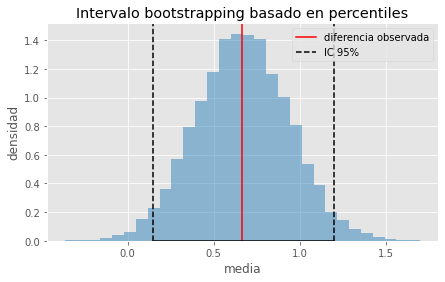

In [180]:
# Gráfico intervalo de confianza del 95%
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_boot, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=cuantiles[0], color='black', linestyle='--', label='IC 95%')
ax.axvline(x=cuantiles[1], color='black', linestyle='--')
ax.hlines(y=0.001, xmin=cuantiles[0], xmax=cuantiles[1], color='black')
ax.set_title('Intervalo bootstrapping basado en percentiles')
ax.set_xlabel('media')
ax.set_ylabel('densidad')
ax.legend();

Sí existen evidencias para afirmar que las visualizaciones promedio de ofertas entre los dos grupos es distinto. El intervalo de confianza del 95% para la diferencia de medias obtenido por bootstrapping indica que, en promedio, las visualizaciones del grupo Telework_Active aumentan hasta de 2 inscripciones promedio


### Teletrabajo posible